# Combining Datasets: Merge and Join

Data often comes from multiple sources and needs to be combined for comprehensive analysis. Pandas provides robust, high-performance, in-memory join and merge operations that perform database-like joins on DataFrames.
The main interface for this is the ``pd.merge`` function, and we'll see few examples of how this can work in practice.

For convenience, we will start by defining the `display()` to display the printed DataFrames side-by-side:

In [1]:
from IPython.display import Pretty as disp
hint = 'https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/docs/hints/'  # path to hints on GitHub

import pandas as pd
import numpy as np

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Relational Algebra

The behavior implemented in ``pd.merge()`` is a subset of what is known as *relational algebra*, which is a formal set of rules for manipulating relational data, and forms the conceptual foundation of operations available in most databases.
The strength of the relational algebra approach is that it proposes several primitive operations, which become the building blocks of more complicated operations on any dataset.
With this lexicon of fundamental operations implemented efficiently in a database or other program, a wide range of fairly complicated composite operations can be performed.

Pandas implements several of these fundamental building-blocks in the ``pd.merge()`` function and the related ``join()`` method of ``Series`` and ``Dataframe``s.
As we will see, these let you efficiently link data from different sources.

## Categories of Joins

The `pd.merge()` function is highly flexible and allows for the merging of DataFrames based on key columns. The choice of keys can influence the type of join being executed—whether it's a one-to-one, many-to-one, or many-to-many relationship between the two datasets. In a one-to-one join, each key in the merging column appears only once in both DataFrames, resulting in a straightforward merge. In a many-to-one join, one DataFrame contains duplicate keys, meaning multiple rows will correspond to a single key in the other DataFrame. Lastly, in a many-to-many join, both DataFrames contain duplicate keys, which results in a Cartesian product of rows for matching keys. These distinctions are essential in business analytics, as the structure of your data determines how results should be interpreted and analyzed. Understanding these types of joins allows analysts to properly prepare data for more advanced modeling and decision-making processes.

### Creating Dummy DataFrames

In [2]:
import pandas as pd

# Create the Customers DataFrame
customers = pd.DataFrame({
    'CustomerID': [1, 2, 3, 4, 5],
    'CustomerName': ['Alice', 'Bob', 'Charlie', 'David', 'Eva'],
    'City': ['Boston', 'Los Angeles', 'Chicago', 'New York City', 'Phoenix'],
    'Region': ['East', 'West', 'Central', 'East', 'West'],
    'AccountStatus': ['Active', 'Inactive', 'Active', 'Active', 'Inactive']
})

# Create the Orders DataFrame
orders = pd.DataFrame({
    'OrderID': [101, 102, 103, 104, 105],
    'CustomerID': [1, 2, 99, 1, 4],
    'OrderDate': ['2024-01-15', '2024-02-20', '2024-03-12', '2024-04-10', '2024-05-18'],
    'OrderAmount': [250, 150, 450, 350, 200],
    'OrderStatus': ['Shipped', 'Pending', 'Delivered', 'Shipped', 'Cancelled']
})

# Create the Products DataFrame
products = pd.DataFrame({
    'ProductID': [1001, 1002, 1003, 1004, 1005],
    'ProductName': ['Laptop', 'Smartphone', 'Tablet', 'Monitor', 'Printer'],
    'Category': ['Electronics', 'Electronics', 'Electronics', 'Peripherals', 'Peripherals'],
    'UnitPrice': [1200, 800, 600, 300, 150],
    'StockLevel': [50, 30, 20, 15, 10]
})

# Create the Sales Representatives DataFrame
sales_reps = pd.DataFrame({
    'RepID': [201, 202, 203, 204],
    'RepName': ['Laura', 'John', 'Mike', 'Nina'],
    'Region': ['East', 'West', 'Central', 'South'],
    'TargetSales': [50000, 40000, 45000, 42000]
})

# Create the Order Items DataFrame
order_items = pd.DataFrame({
    'OrderID': [101, 101, 102, 103, 104],
    'Product_ID': [1001, 1003, 1002, 1005, 1004],
    'Quantity': [2, 1, 1, 3, 2],
    'UnitPrice': [1200, 600, 800, 150, 300],
    'Discount': [0.1, 0.05, 0.2, 0.0, 0.15]
})

display('customers', 'orders', 'products', 'sales_reps', 'order_items')

customers
   CustomerID CustomerName           City   Region AccountStatus
0           1        Alice         Boston     East        Active
1           2          Bob    Los Angeles     West      Inactive
2           3      Charlie        Chicago  Central        Active
3           4        David  New York City     East        Active
4           5          Eva        Phoenix     West      Inactive

orders
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus
0      101           1  2024-01-15          250     Shipped
1      102           2  2024-02-20          150     Pending
2      103          99  2024-03-12          450   Delivered
3      104           1  2024-04-10          350     Shipped
4      105           4  2024-05-18          200   Cancelled

products
   ProductID ProductName     Category  UnitPrice  StockLevel
0       1001      Laptop  Electronics       1200          50
1       1002  Smartphone  Electronics        800          30
2       1003      Tablet  Electronics        600          20
3       1004     Monitor  Peripherals        300          15
4       1005     Printer  Peripherals        150          10

sales_reps
   RepID RepName   Region  TargetSales
0    201   Laura     East        50000
1    202    John     West        40000
2    203    Mike  Central        45000
3    204    Nina    South        42000

order_items
   OrderID  Product_ID  Quantity  UnitPrice  Discount
0      101        1001         2       1200      0.10
1      101        1003         1        600      0.05
2      102        1002         1        800      0.20
3      103        1005         3        150      0.00
4      104        1004         2        300      0.15

## Types of Joins
Pandas supports several types of joins, similar to SQL:

* **Inner Join:** Returns only the rows with matching keys in both DataFrames.
* **Left Join:** Returns all rows from the left DataFrame and the matched rows from the right DataFrame. If there is no match, the result is `NaN` on the right side.
* **Right Join:** Returns all rows from the right DataFrame and the matched rows from the left DataFrame. If there is no match, the result is `NaN` on the left side.
* **Outer Join:** Returns all rows when there is a match in either left or right DataFrame. If there is no match, the missing side will contain `NaN`.


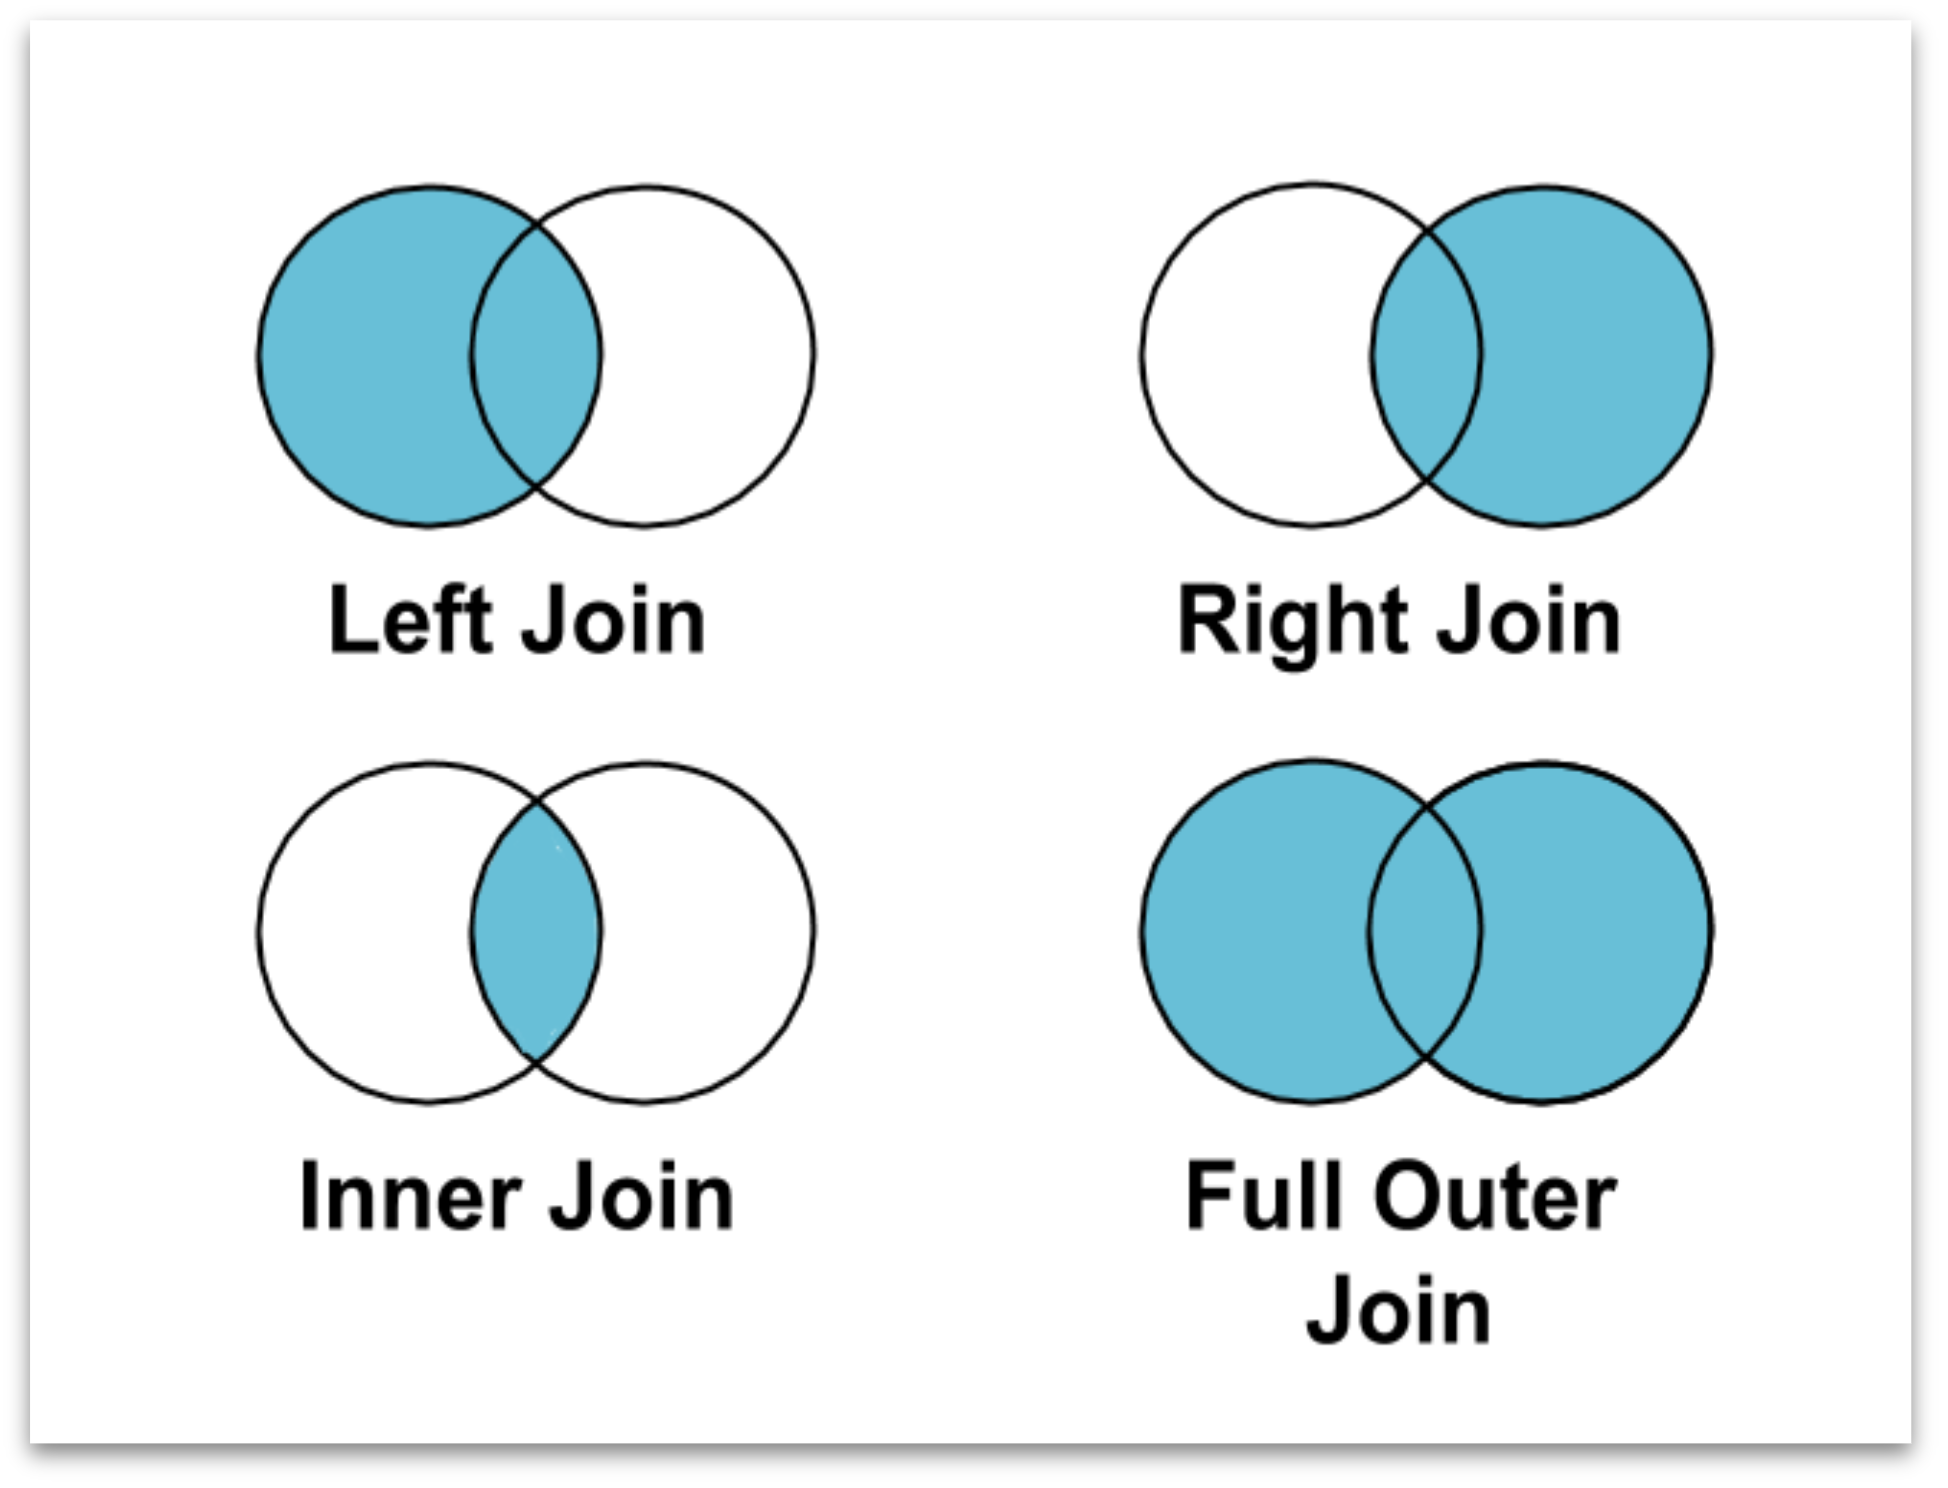

## Performing Joins with `pd.merge()`

The basic syntax for `pd.merge()` is:

```python
pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None, ...)
```

**left:** The left DataFrame.

**right:** The right DataFrame.

**how:** Type of join {'left', 'right', 'outer', 'inner', 'cross'}, default 'inner'.

**on:** Column name(s) to join on. Must be present in both DataFrames.

**left_on:** Column name(s) from the left DataFrame to join on.

**right_on:** Column name(s) from the right DataFrame to join on.

Example:

```python
merged_df = pd.merge(customers, orders, how='inner', on='CustomerID')
```

This performs an inner join on the `CustomerID` column.

## Practical Examples

Let's dive into some practical examples using the provided DataFrames.

### **Inner Join:** Customers and Orders

Retrieve all customers who have placed orders along with their order details.

In [ ]:
inner_join_df = pd.merge(customers, orders, how='inner', on='CustomerID')
display('customers', 'orders', 'inner_join_df')

customers
   CustomerID CustomerName           City   Region AccountStatus
0           1        Alice         Boston     East        Active
1           2          Bob    Los Angeles     West      Inactive
2           3      Charlie        Chicago  Central        Active
3           4        David  New York City     East        Active
4           5          Eva        Phoenix     West      Inactive

orders
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus
0      101           1  2024-01-15          250     Shipped
1      102           2  2024-02-20          150     Pending
2      103          99  2024-03-12          450   Delivered
3      104           1  2024-04-10          350     Shipped
4      105           4  2024-05-18          200   Cancelled

inner_join_df
   CustomerID CustomerName           City Region AccountStatus  OrderID  \
0           1        Alice         Boston   East        Active      101   
1           1        Alice         Boston   East        Active      104   
2           2          Bob    Los Angeles   West      Inactive      102   
3           4        David  New York City   East        Active      105   

    OrderDate  OrderAmount OrderStatus  
0  2024-01-15          250     Shipped  
1  2024-04-10          350     Shipped  
2  2024-02-20          150     Pending  
3  2024-05-18          200   Cancelled

* Only customers with matching `CustomerID` in both DataFrames are included.
* Customer "Eva" (`CustomerID` 5) has no orders and is excluded.

### **Left Join:** Customers and Orders
Retrieve all customers and their orders. Include the customers who haven't placed an order.

In [ ]:
left_join_df = pd.merge(customers, orders, how='left', on='CustomerID')
display('customers', 'orders', 'left_join_df')

customers
   CustomerID CustomerName           City   Region AccountStatus
0           1        Alice         Boston     East        Active
1           2          Bob    Los Angeles     West      Inactive
2           3      Charlie        Chicago  Central        Active
3           4        David  New York City     East        Active
4           5          Eva        Phoenix     West      Inactive

orders
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus
0      101           1  2024-01-15          250     Shipped
1      102           2  2024-02-20          150     Pending
2      103          99  2024-03-12          450   Delivered
3      104           1  2024-04-10          350     Shipped
4      105           4  2024-05-18          200   Cancelled

left_join_df
   CustomerID CustomerName           City   Region AccountStatus  OrderID  \
0           1        Alice         Boston     East        Active    101.0   
1           1        Alice         Boston     East        Active    104.0   
2           2          Bob    Los Angeles     West      Inactive    102.0   
3           3      Charlie        Chicago  Central        Active      NaN   
4           4        David  New York City     East        Active    105.0   
5           5          Eva        Phoenix     West      Inactive      NaN   

    OrderDate  OrderAmount OrderStatus  
0  2024-01-15        250.0     Shipped  
1  2024-04-10        350.0     Shipped  
2  2024-02-20        150.0     Pending  
3         NaN          NaN         NaN  
4  2024-05-18        200.0   Cancelled  
5         NaN          NaN         NaN

* All customers are included.
* Customers without orders (e.g., Eva) have `NaN` values for order-related columns.
* Since there is a possibility of duplicate matches (e.g., Alice has multiple orders), we see more rows than `customers` DataFrames.

### **Right Join:** Orders and Sales Representatives
Assume each sales representative is responsible for a specific region. Retrieve all orders along with the corresponding sales representative's details based on the customer's region.

We'll join `orders` with `sales_reps` based on the `Region` from `customers`.

Steps:

1. First, merge `orders` with `customers` to get the `Region` for each `order`.
2. Then, perform a right join with `sales_reps` to get the sales representative details.

In [ ]:
# Step 1: Merge orders with customers to get Region
orders_customers = pd.merge(orders, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

display('orders', 'customers', 'orders_customers')

orders
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus
0      101           1  2024-01-15          250     Shipped
1      102           2  2024-02-20          150     Pending
2      103          99  2024-03-12          450   Delivered
3      104           1  2024-04-10          350     Shipped
4      105           4  2024-05-18          200   Cancelled

customers
   CustomerID CustomerName           City   Region AccountStatus
0           1        Alice         Boston     East        Active
1           2          Bob    Los Angeles     West      Inactive
2           3      Charlie        Chicago  Central        Active
3           4        David  New York City     East        Active
4           5          Eva        Phoenix     West      Inactive

orders_customers
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus Region
0      101           1  2024-01-15          250     Shipped   East
1      102           2  2024-02-20          150     Pending   West
2      103          99  2024-03-12          450   Delivered    NaN
3      104           1  2024-04-10          350     Shipped   East
4      105           4  2024-05-18          200   Cancelled   East

In [ ]:
# Step 2: Right Join with sales_reps on Region
right_join_df = pd.merge(orders_customers, sales_reps, how='right', on='Region')

display('orders_customers', 'sales_reps', 'right_join_df')

orders_customers
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus Region
0      101           1  2024-01-15          250     Shipped   East
1      102           2  2024-02-20          150     Pending   West
2      103          99  2024-03-12          450   Delivered    NaN
3      104           1  2024-04-10          350     Shipped   East
4      105           4  2024-05-18          200   Cancelled   East

sales_reps
   RepID RepName   Region  TargetSales
0    201   Laura     East        50000
1    202    John     West        40000
2    203    Mike  Central        45000
3    204    Nina    South        42000

right_join_df
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus   Region  RepID  \
0    101.0         1.0  2024-01-15        250.0     Shipped     East    201   
1    104.0         1.0  2024-04-10        350.0     Shipped     East    201   
2    105.0         4.0  2024-05-18        200.0   Cancelled     East    201   
3    102.0         2.0  2024-02-20        150.0     Pending     West    202   
4      NaN         NaN         NaN          NaN         NaN  Central    203   
5      NaN         NaN         NaN          NaN         NaN    South    204   

  RepName  TargetSales  
0   Laura        50000  
1   Laura        50000  
2   Laura        50000  
3    John        40000  
4    Mike        45000  
5    Nina        42000

* All sales representatives are included (right join).
* Orders are matched based on the `Region`.
* If a sales representative's region has no corresponding orders, the order-related fields would be NaN (e.g., Nina from the South region).

### **Outer Join:** Customers and Orders
Retrieve all customers and all orders.

In [ ]:
outer_join_df = pd.merge(customers, orders, on='CustomerID', how='outer', indicator=True)

display('customers', 'orders', 'outer_join_df')

customers
   CustomerID CustomerName           City   Region AccountStatus
0           1        Alice         Boston     East        Active
1           2          Bob    Los Angeles     West      Inactive
2           3      Charlie        Chicago  Central        Active
3           4        David  New York City     East        Active
4           5          Eva        Phoenix     West      Inactive

orders
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus
0      101           1  2024-01-15          250     Shipped
1      102           2  2024-02-20          150     Pending
2      103          99  2024-03-12          450   Delivered
3      104           1  2024-04-10          350     Shipped
4      105           4  2024-05-18          200   Cancelled

outer_join_df
   CustomerID CustomerName           City   Region AccountStatus  OrderID  \
0           1        Alice         Boston     East        Active    101.0   
1           1        Alice         Boston     East        Active    104.0   
2           2          Bob    Los Angeles     West      Inactive    102.0   
3           3      Charlie        Chicago  Central        Active      NaN   
4           4        David  New York City     East        Active    105.0   
5           5          Eva        Phoenix     West      Inactive      NaN   
6          99          NaN            NaN      NaN           NaN    103.0   

    OrderDate  OrderAmount OrderStatus      _merge  
0  2024-01-15        250.0     Shipped        both  
1  2024-04-10        350.0     Shipped        both  
2  2024-02-20        150.0     Pending        both  
3         NaN          NaN         NaN   left_only  
4  2024-05-18        200.0   Cancelled        both  
5         NaN          NaN         NaN   left_only  
6  2024-03-12        450.0   Delivered  right_only

### Joining Multiple DataFrames: Orders, Order Items, and Products
Retrieve detailed information about each order, including customer details, order items, and product information.

Steps:

1. Merge `orders` with `customers` to get customer details.
2. Merge the result with `order_items` on `OrderID`.
3. Merge the above with `products` on `ProductID`.

Don't leave out any orders, even if the customer or other order details are not known.

In [3]:
# Step 1: Merge orders with customers
orders_customers = pd.merge(orders, customers, on='CustomerID', how='left')

display('orders', 'customers', 'orders_customers')

orders
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus
0      101           1  2024-01-15          250     Shipped
1      102           2  2024-02-20          150     Pending
2      103          99  2024-03-12          450   Delivered
3      104           1  2024-04-10          350     Shipped
4      105           4  2024-05-18          200   Cancelled

customers
   CustomerID CustomerName           City   Region AccountStatus
0           1        Alice         Boston     East        Active
1           2          Bob    Los Angeles     West      Inactive
2           3      Charlie        Chicago  Central        Active
3           4        David  New York City     East        Active
4           5          Eva        Phoenix     West      Inactive

orders_customers
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus CustomerName  \
0      101           1  2024-01-15          250     Shipped        Alice   
1      102           2  2024-02-20          150     Pending          Bob   
2      103          99  2024-03-12          450   Delivered          NaN   
3      104           1  2024-04-10          350     Shipped        Alice   
4      105           4  2024-05-18          200   Cancelled        David   

            City Region AccountStatus  
0         Boston   East        Active  
1    Los Angeles   West      Inactive  
2            NaN    NaN           NaN  
3         Boston   East        Active  
4  New York City   East        Active

In [4]:
# Step 2: Merge with order_items
orders_customers_items = pd.merge(orders_customers, order_items, on='OrderID', how='left')

display('orders_customers', 'order_items', 'orders_customers_items')

orders_customers
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus CustomerName  \
0      101           1  2024-01-15          250     Shipped        Alice   
1      102           2  2024-02-20          150     Pending          Bob   
2      103          99  2024-03-12          450   Delivered          NaN   
3      104           1  2024-04-10          350     Shipped        Alice   
4      105           4  2024-05-18          200   Cancelled        David   

            City Region AccountStatus  
0         Boston   East        Active  
1    Los Angeles   West      Inactive  
2            NaN    NaN           NaN  
3         Boston   East        Active  
4  New York City   East        Active  

order_items
   OrderID  Product_ID  Quantity  UnitPrice  Discount
0      101        1001         2       1200      0.10
1      101        1003         1        600      0.05
2      102        1002         1        800      0.20
3      103        1005         3        150      0.00
4      104        1004         2        300      0.15

orders_customers_items
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus CustomerName  \
0      101           1  2024-01-15          250     Shipped        Alice   
1      101           1  2024-01-15          250     Shipped        Alice   
2      102           2  2024-02-20          150     Pending          Bob   
3      103          99  2024-03-12          450   Delivered          NaN   
4      104           1  2024-04-10          350     Shipped        Alice   
5      105           4  2024-05-18          200   Cancelled        David   

            City Region AccountStatus  Product_ID  Quantity  UnitPrice  \
0         Boston   East        Active      1001.0       2.0     1200.0   
1         Boston   East        Active      1003.0       1.0      600.0   
2    Los Angeles   West      Inactive      1002.0       1.0      800.0   
3            NaN    NaN           NaN      1005.0       3.0      150.0   
4         Boston   East        Active      1004.0       2.0      300.0   
5  New York City   East        Active         NaN       NaN        NaN   

   Discount  
0      0.10  
1      0.05  
2      0.20  
3      0.00  
4      0.15  
5       NaN

In [ ]:
# Step 3: Merge with products
detailed_orders = pd.merge(orders_customers_items, products, left_on='Product_ID', right_on='ProductID', how='left', suffixes=('_Order', '_Prod')).drop('Product_ID', axis=1)

display('orders_customers_items', 'products', 'detailed_orders')

orders_customers_items
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus CustomerName  \
0      101           1  2024-01-15          250     Shipped        Alice   
1      101           1  2024-01-15          250     Shipped        Alice   
2      102           2  2024-02-20          150     Pending          Bob   
3      103          99  2024-03-12          450   Delivered          NaN   
4      104           1  2024-04-10          350     Shipped        Alice   
5      105           4  2024-05-18          200   Cancelled        David   

            City Region AccountStatus  Product_ID  Quantity  UnitPrice  \
0         Boston   East        Active      1001.0       2.0     1200.0   
1         Boston   East        Active      1003.0       1.0      600.0   
2    Los Angeles   West      Inactive      1002.0       1.0      800.0   
3            NaN    NaN           NaN      1005.0       3.0      150.0   
4         Boston   East        Active      1004.0       2.0      300.0   
5  New York City   East        Active         NaN       NaN        NaN   

   Discount  
0      0.10  
1      0.05  
2      0.20  
3      0.00  
4      0.15  
5       NaN  

products
   ProductID ProductName     Category  UnitPrice  StockLevel
0       1001      Laptop  Electronics       1200          50
1       1002  Smartphone  Electronics        800          30
2       1003      Tablet  Electronics        600          20
3       1004     Monitor  Peripherals        300          15
4       1005     Printer  Peripherals        150          10

detailed_orders
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus CustomerName  \
0      101           1  2024-01-15          250     Shipped        Alice   
1      101           1  2024-01-15          250     Shipped        Alice   
2      102           2  2024-02-20          150     Pending          Bob   
3      103          99  2024-03-12          450   Delivered          NaN   
4      104           1  2024-04-10          350     Shipped        Alice   
5      105           4  2024-05-18          200   Cancelled        David   

            City Region AccountStatus  Quantity  UnitPrice_Order  Discount  \
0         Boston   East        Active       2.0           1200.0      0.10   
1         Boston   East        Active       1.0            600.0      0.05   
2    Los Angeles   West      Inactive       1.0            800.0      0.20   
3            NaN    NaN           NaN       3.0            150.0      0.00   
4         Boston   East        Active       2.0            300.0      0.15   
5  New York City   East        Active       NaN              NaN       NaN   

   ProductID ProductName     Category  UnitPrice_Prod  StockLevel  
0     1001.0      Laptop  Electronics          1200.0        50.0  
1     1003.0      Tablet  Electronics           600.0        20.0  
2     1002.0  Smartphone  Electronics           800.0        30.0  
3     1005.0     Printer  Peripherals           150.0        10.0  
4     1004.0     Monitor  Peripherals           300.0        15.0  
5        NaN         NaN          NaN             NaN         NaN

* Each row represents an order item with comprehensive details.
* Includes customer information, order details, product details, and pricing.
* We have used `suffixes=('_Order', '_Prod')` for columns with identical names in both tables (`UnitPrice` here) to be distinguished.
* `left_on='Product_ID', right_on='ProductID'` is used to specify which columns to join, instead of `on` since the keys have different column names.
    * The `left_index` and `right_index` keywords would be used if we want to merge on an index.
        * Alternatively, in pandas, the `.join()` method can be used to join DataFrames based on their indexes, simplifying the process of merging on index columns without explicitly specifying `left_index` and `right_index`.
        ```python
        # First, we need to set the index to 'Product_ID' in orders_customers_items and 'ProductID' in products
        orders_customers_items.set_index('Product_ID', inplace=True)
        products.set_index('ProductID', inplace=True)

        # Now we can use the .join() method to join on the index
        detailed_orders = orders_customers_items.join(products, how='left', lsuffix='_Order', rsuffix='_Prod').reset_index()

        # If you don't want the 'Product_ID' in the result, you can drop it
        detailed_orders = detailed_orders.drop('Product_ID', axis=1)

        display('orders_customers_items', 'products', 'detailed_orders')

        ```
* `.drop('Product_ID', axis=1)` is used to drop the duplicate column.


## Filtering Joins

### **Semi-Join:** Customers Who Have Placed Orders
A semi-join returns all rows from the left DataFrame where there are matching values in the right DataFrame, but without duplicating columns from the right DataFrame.

In pandas, a semi-join is not directly supported as a specific function, but it can be achieved by filtering rows in one DataFrame based on the presence of matching values in another DataFrame.



In [ ]:
customer_ids_with_orders = orders['CustomerID'].unique()
customers_with_orders = customers[customers['CustomerID'].isin(customer_ids_with_orders)]
display('orders', 'customers', 'customers_with_orders')

orders
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus
0      101           1  2024-01-15          250     Shipped
1      102           2  2024-02-20          150     Pending
2      103          99  2024-03-12          450   Delivered
3      104           1  2024-04-10          350     Shipped
4      105           4  2024-05-18          200   Cancelled

customers
   CustomerID CustomerName           City   Region AccountStatus
0           1        Alice         Boston     East        Active
1           2          Bob    Los Angeles     West      Inactive
2           3      Charlie        Chicago  Central        Active
3           4        David  New York City     East        Active
4           5          Eva        Phoenix     West      Inactive

customers_with_orders
   CustomerID CustomerName           City Region AccountStatus
0           1        Alice         Boston   East        Active
1           2          Bob    Los Angeles   West      Inactive
3           4        David  New York City   East        Active

* We filtered customers to include only those who have placed orders.

### **Anti-Join:** Customers Who Have Not Placed Orders
An anti-join returns all rows from the left DataFrame where there are no matching values in the right DataFrame.

In [ ]:
customer_ids_with_orders = orders['CustomerID'].unique()
customers_without_orders = customers[~customers['CustomerID'].isin(customer_ids_with_orders)]
display('orders', 'customers', 'customers_without_orders')

orders
   OrderID  CustomerID   OrderDate  OrderAmount OrderStatus
0      101           1  2024-01-15          250     Shipped
1      102           2  2024-02-20          150     Pending
2      103          99  2024-03-12          450   Delivered
3      104           1  2024-04-10          350     Shipped
4      105           4  2024-05-18          200   Cancelled

customers
   CustomerID CustomerName           City   Region AccountStatus
0           1        Alice         Boston     East        Active
1           2          Bob    Los Angeles     West      Inactive
2           3      Charlie        Chicago  Central        Active
3           4        David  New York City     East        Active
4           5          Eva        Phoenix     West      Inactive

customers_without_orders
   CustomerID CustomerName     City   Region AccountStatus
2           3      Charlie  Chicago  Central        Active
4           5          Eva  Phoenix     West      Inactive

For more details, see the ["Merge, Join, and Concatenate" section](http://pandas.pydata.org/pandas-docs/stable/merging.html) of the Pandas documentation.

# Your turn

In the following cell we are loading two datasets: 1) `movies`, consists of metadata information about 1682 movies from 1969 to 1995. 2) `ratings`, includes 100,000 ratings on these movies.

In [ ]:
movies = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/data/movies_metadata.csv', encoding='latin-1')  # encoding='latin-1' was used
ratings = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/data/movies_ratings.csv', sep='\t')  # tab separated data
display('ratings.head()', 'movies.head()')

ratings.head()
   user_id  movie_id  rating  rating_timestamp
0      196       242       3         881250949
1      186       302       3         891717742
2       22       377       1         878887116
3      244        51       2         880606923
4      166       346       1         886397596

movies.head()
   movie_id        movie_title release_date  \
0         1   Toy Story (1995)     1-Jan-95   
1         2   GoldenEye (1995)     1-Jan-95   
2         3  Four Rooms (1995)     1-Jan-95   
3         4  Get Shorty (1995)     1-Jan-95   
4         5     Copycat (1995)     1-Jan-95   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...      0.0     0.0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...      0.0     1.0   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...      0.0     0.0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...      0.0     1.0   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)      0.0     0.0   

   Adventure  Animation  Childrens  Comedy  ...  Fantasy  Film_Noir  Horror  \
0        0.0        1.0        1.0     1.0  ...      0.0        0.0     0.0   
1        1.0        0.0        0.0     0.0  ...      0.0        0.0     0.0   
2        0.0        0.0        0.0     0.0  ...      0.0        0.0     0.0   
3        0.0        0.0        0.0     1.0  ...      0.0        0.0     0.0   
4        0.0        0.0        0.0     0.0  ...      0.0        0.0     0.0   

   Musical  Mystery  Romance  Sci_Fi  Thriller  War  Western  
0      0.0      0.0      0.0     0.0       0.0  0.0      0.0  
1      0.0      0.0      0.0     0.0       1.0  0.0      0.0  
2      0.0      0.0      0.0     0.0       1.0  0.0      0.0  
3      0.0      0.0      0.0     0.0       0.0  0.0      0.0  
4      0.0      0.0      0.0     0.0       1.0  0.0      0.0  

[5 rows x 23 columns]

We only need the movie title and ID from `movies`; let's select only those two columns and get rid of the rest:

In [ ]:
# Your code goes here


In [ ]:
movies.head(2)

movie_id       movie_title
0         1  Toy Story (1995)
1         2  GoldenEye (1995)

In [ ]:
# SOLUTION: Uncomment and execute the cell below to get help
#disp(hint + '09-03-select-columns')

From the `ratings` dataframe find the average rating for each movie_id and save it to a DataFrame called `avg_rating`:

In [ ]:
# Your code goes here


In [ ]:
avg_rating.head()

rating
movie_id          
1         3.878319
2         3.206107
3         3.033333
4         3.550239
5         3.302326

In [ ]:
# HINT: Uncomment and execute the line below to get help
#disp(hint + '09-03-agg-hint')

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-agg')

Merge `movies` with `avg_rating` DataFrame to bring the title name of each movie_id. Call this DataFrame `avg_rating_w_title`:

In [ ]:
# Your code goes here


In [ ]:
avg_rating_w_title.head()

rating  movie_id        movie_title
0  3.878319         1   Toy Story (1995)
1  3.206107         2   GoldenEye (1995)
2  3.033333         3  Four Rooms (1995)
3  3.550239         4  Get Shorty (1995)
4  3.302326         5     Copycat (1995)

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-merge-movies')

Let's sort the columns of `avg_rating_w_title` in the order of `movie_title` | `rating` and make the `movie_id` the index. No need to provide a new name for this dataframe, just overwrite it:

In [ ]:
# Your code goes here


In [ ]:
avg_rating_w_title.head()

movie_title    rating
movie_id                             
1          Toy Story (1995)  3.878319
2          GoldenEye (1995)  3.206107
3         Four Rooms (1995)  3.033333
4         Get Shorty (1995)  3.550239
5            Copycat (1995)  3.302326

In [ ]:
# HINT: Uncomment and execute the line below to get help
#disp(hint + '09-03-sort-columns')

Sort this `avg_rating_w_title` DataFrame inplace (top rated movies on top):

In [ ]:
# Your code goes here


In [ ]:
avg_rating_w_title

movie_title  rating
movie_id                                                           
814                                     Great Day in Harlem     5.0
1599                          Someone Else's America (1995)     5.0
1201             Marlene Dietrich: Shadow and Light (1996)      5.0
1122                         They Made Me a Criminal (1939)     5.0
1653      Entertaining Angels: The Dorothy Day Story (1996)     5.0
...                                                     ...     ...
1568                           Vermont Is For Lovers (1992)     1.0
1567                                         Careful (1992)     1.0
1566                                    Man from Down Under     1.0
1565                                           Daens (1992)     1.0
852                                            Bloody Child     1.0

[1682 rows x 2 columns]

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-sort-movies')

# Your turn

Let's find out how many ratings each movie had and then join it with `avg_rating_w_title`.

First, using groupby count the number of ratings for each `movie_id`. Call the resulting DataFrame `n_rating`. Use column `movie_id` for counting and call the resulting column in this dataframe `n_rating`:

In [ ]:
# Your code goes here


In [ ]:
display('avg_rating_w_title.head()', 'n_rating.head()')

avg_rating_w_title.head()
                                                movie_title  rating
movie_id                                                           
814                                     Great Day in Harlem     5.0
1599                          Someone Else's America (1995)     5.0
1201             Marlene Dietrich: Shadow and Light (1996)      5.0
1122                         They Made Me a Criminal (1939)     5.0
1653      Entertaining Angels: The Dorothy Day Story (1996)     5.0

n_rating.head()
          n_ratings
movie_id           
1               452
2               131
3                90
4               209
5                86

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-count_rating')

Merge (join) `avg_rating_w_title` and `n_rating`, call it `movie_rating`:

In [ ]:
# Your code goes here


In [ ]:
movie_rating.head()

movie_title  rating  n_ratings
movie_id                                                                      
814                                     Great Day in Harlem     5.0          1
1599                          Someone Else's America (1995)     5.0          1
1201             Marlene Dietrich: Shadow and Light (1996)      5.0          1
1122                         They Made Me a Criminal (1939)     5.0          1
1653      Entertaining Angels: The Dorothy Day Story (1996)     5.0          1

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-movie_rating')

Since `avg_rating` was already sorted this will give us a sorted DataFrame. Let's take out all the movies that don't have at least 200 votes. Also, replace the index by `movie_title`:

In [ ]:
# Your code goes here


In [ ]:
movie_rating.head(10)

rating  n_ratings
movie_title                                                
Schindler's List (1993)                 4.466443        298
Casablanca (1942)                       4.456790        243
Shawshank Redemption                    4.445230        283
Rear Window (1954)                      4.387560        209
Usual Suspects                          4.385768        267
Star Wars (1977)                        4.358491        583
To Kill a Mockingbird (1962)            4.292237        219
One Flew Over the Cuckoo's Nest (1975)  4.291667        264
Silence of the Lambs                    4.289744        390
Godfather                               4.283293        413

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-filter-movies')

# Combining Datasets: Concatenate (UNION)
We can combine or concatenate datasets of the same shape with the same column names and data types. This is particularely useful when store datasets for different years in different files/dataframes and for certain analyses would want to combine them. Here is a simple example:

In [ ]:
sales_2020 = pd.DataFrame({'customer_id': ['CGN-201', 'CGN-202'],
                    'total_purchase': [100, 150]})

sales_2019 = pd.DataFrame({'customer_id': ['CGN-191', 'CGN-192', 'CGN-193'],
                    'total_purchase': [120, 90, 450]})

sales_2018 = pd.DataFrame({'customer_id': ['CGN-181'],
                    'total_purchase': [50]})

print('sales_2020:')
print(sales_2020)
print('\nsales_2019:\n')
print(sales_2019)
print('\nsales_2018:\n')
print(sales_2018)

sales_2020:
  customer_id  total_purchase
0     CGN-201             100
1     CGN-202             150

sales_2019:

  customer_id  total_purchase
0     CGN-191             120
1     CGN-192              90
2     CGN-193             450

sales_2018:

  customer_id  total_purchase
0     CGN-181              50


In [ ]:
pd.concat([sales_2020, sales_2019, sales_2018])

customer_id  total_purchase
0     CGN-201             100
1     CGN-202             150
0     CGN-191             120
1     CGN-192              90
2     CGN-193             450
0     CGN-181              50

We could reset the index:

In [ ]:
pd.concat([sales_2020, sales_2019, sales_2018]).reset_index()

index customer_id  total_purchase
0      0     CGN-201             100
1      1     CGN-202             150
2      0     CGN-191             120
3      1     CGN-192              90
4      2     CGN-193             450
5      0     CGN-181              50

# Exercise: US States Data

Merge and join operations come up most often when combining data from different sources.

Here we will consider an example of some data about US states and their populations.

Let's take a look at the three datasets, using the Pandas ``read_csv()`` function:

In [ ]:
pop = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/data/state-population.csv')
areas = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/data/state-areas.csv')
abbrevs = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/data/state-abbrevs.csv')

display('pop.head()', 'areas.head()', 'abbrevs.head()')

pop.head()
  state/region     ages  year  population
0           AL  under18  2012   1117489.0
1           AL    total  2012   4817528.0
2           AL  under18  2010   1130966.0
3           AL    total  2010   4785570.0
4           AL  under18  2011   1125763.0

areas.head()
        state  area (sq. mi)
0     Alabama          52423
1      Alaska         656425
2     Arizona         114006
3    Arkansas          53182
4  California         163707

abbrevs.head()
        state abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA

Given this information, say we want to compute a relatively straightforward result: **rank US states and territories by their 2010 population density.**

We clearly have the data here to find this result, but we'll have to combine the datasets to find the result.

You can try to find the answer to this question without using any help, but if you found yourself stuck, below you will find the step by step guide.

Feel free to uncomment the hints as needed.

In [ ]:
# Your answer goes here


## Step-by-step guide
We'll start with a many-to-one merge that will give us the full state name within the population ``DataFrame``.

### Merge `pop` & `abbrevs` DataFrames

We want to merge based on the ``state/region``  column of ``pop``, and the ``abbreviation`` column of ``abbrevs``.

We'll use ``how='outer'`` to make sure no data is thrown away due to mismatched labels.

Call the resulted DataFrame `merged`. Also drop the "abbreviation" column since it's duplicate.

In [ ]:
# Your answer goes here


In [ ]:
merged.head()

state/region     ages  year  population    state
0           AL  under18  2012   1117489.0  Alabama
1           AL    total  2012   4817528.0  Alabama
2           AL  under18  2010   1130966.0  Alabama
3           AL    total  2010   4785570.0  Alabama
4           AL  under18  2011   1125763.0  Alabama

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-merge_pop_abr')

Let's double-check whether there were any mismatches here, which we can do by looking for rows with nulls:

1. Apply `isnull()` method on this DataFrame
2. Chain a `sum()` to this to get the count of NAs for each column

In [ ]:
# Your answer goes here


In [ ]:
# Don't run this cell to keep the outcome as your frame of reference
merged.isnull().sum()

state/region     0
ages             0
year             0
population      20
state           96
dtype: int64

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-isnull')

Some of the ``population`` info is null; let's figure out which ones they are!

Subset our `merged` DataFrame by `merged['population'].isnull()` as the condition. I.e., `DF[condition]`.

Checkout out the first few rows

In [ ]:
# Your answer goes here


In [ ]:
# Don't run this cell to keep the outcome as your frame of reference
merged[merged['population'].isnull()].head()

state/region     ages  year  population state
2448           PR  under18  1990         NaN   NaN
2449           PR    total  1990         NaN   NaN
2450           PR    total  1991         NaN   NaN
2451           PR  under18  1991         NaN   NaN
2452           PR    total  1993         NaN   NaN

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-condition')

It appears that all the null population values are from Puerto Rico prior to the year 2000; this is likely due to this data not being available from the original source.

More importantly, we see also that some of the new ``state`` entries are also null, which means that there was no corresponding entry in the ``abbrevs`` key!
Let's figure out which regions lack this match:

In [ ]:
merged.loc[merged['state'].isnull(), 'state/region'].unique()

array(['PR', 'USA'], dtype=object)

We can quickly infer the issue: our population data includes entries for Puerto Rico (PR) and the United States as a whole (USA), while these entries do not appear in the state abbreviation key.
We can fix these quickly by filling in appropriate entries:

In [ ]:
merged.loc[merged['state/region'] == 'PR', 'state'] = 'Puerto Rico'

Do the same with 'USA' and pass 'United States' as the value for `state`:

In [ ]:
# Your answer goes here


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-replace')

In [ ]:
merged.isnull().sum()

state/region     0
ages             0
year             0
population      20
state            0
dtype: int64

No more nulls in the ``state`` column: we're all set!

Now we can merge the result with the `area` data using a similar procedure.

Examining our results, we will want to join on the ``state`` column in both.

Call this new DataFrame `final`:

In [ ]:
# Your answer goes here


In [ ]:
final.head()

state/region     ages  year  population    state  area (sq. mi)
0           AL  under18  2012   1117489.0  Alabama        52423.0
1           AL    total  2012   4817528.0  Alabama        52423.0
2           AL  under18  2010   1130966.0  Alabama        52423.0
3           AL    total  2010   4785570.0  Alabama        52423.0
4           AL  under18  2011   1125763.0  Alabama        52423.0

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-final')

Again, let's check for nulls to see if there were any mismatches:

In [ ]:
final.isnull().sum()

state/region      0
ages              0
year              0
population       20
state             0
area (sq. mi)    48
dtype: int64

There are nulls in the ``area`` column; we can take a look to see which regions were ignored here:

In [ ]:
final.loc[final['area (sq. mi)'].isnull(), 'state'].unique()

array(['United States'], dtype=object)

We see that our ``areas`` ``DataFrame`` does not contain the area of the United States as a whole.
We could insert the appropriate value (using the sum of all state areas, for instance), but in this case we'll just drop the null values because the population density of the entire United States is not relevant to our current discussion:

In [ ]:
# Your answer goes here


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-dropna')

Now we have all the data we need. To answer the question of interest, let's first select the portion of the data corresponding with the year 2010, and the total population.

Call this new DataFrame `data2010` and make sure it's a separate copy (by adding `.copy()` at the end of the statement that subsets the DF):

In [ ]:
# Your answer goes here


In [ ]:
data2010.head()

state/region   ages  year  population       state  area (sq. mi)
3             AL  total  2010   4785570.0     Alabama        52423.0
91            AK  total  2010    713868.0      Alaska       656425.0
101           AZ  total  2010   6408790.0     Arizona       114006.0
189           AR  total  2010   2922280.0    Arkansas        53182.0
197           CA  total  2010  37333601.0  California       163707.0

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-data2010')

Now let's compute the population density and display it in order.
We'll start by re-indexing our data on the state. Use method `set_index()`. Read the help page to see how to do this "inplace".

In [ ]:
# Your answer goes here


In [ ]:
data2010.head()

state/region   ages  year  population  area (sq. mi)
state                                                          
Alabama              AL  total  2010   4785570.0        52423.0
Alaska               AK  total  2010    713868.0       656425.0
Arizona              AZ  total  2010   6408790.0       114006.0
Arkansas             AR  total  2010   2922280.0        53182.0
California           CA  total  2010  37333601.0       163707.0

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-setindex')

and then compute the result by creating a new column called "density":

In [ ]:
data2010['density'] = data2010['population'] / data2010['area (sq. mi)']
data2010.head()

state/region   ages  year  population  area (sq. mi)     density
state                                                                      
Alabama              AL  total  2010   4785570.0        52423.0   91.287603
Alaska               AK  total  2010    713868.0       656425.0    1.087509
Arizona              AZ  total  2010   6408790.0       114006.0   56.214497
Arkansas             AR  total  2010   2922280.0        53182.0   54.948667
California           CA  total  2010  37333601.0       163707.0  228.051342

Sort this `data2010` DataFrame by "density" column in descending order and make sure it's "inplace":

In [ ]:
# Your answer goes here


In [ ]:
data2010.head()

state/region   ages  year  population  area (sq. mi)  \
state                                                                       
District of Columbia           DC  total  2010    605125.0           68.0   
Puerto Rico                    PR  total  2010   3721208.0         3515.0   
New Jersey                     NJ  total  2010   8802707.0         8722.0   
Rhode Island                   RI  total  2010   1052669.0         1545.0   
Connecticut                    CT  total  2010   3579210.0         5544.0   

                          density  
state                              
District of Columbia  8898.897059  
Puerto Rico           1058.665149  
New Jersey            1009.253268  
Rhode Island           681.339159  
Connecticut            645.600649

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-data2010sort')

The result is a ranking of US states plus Washington, DC, and Puerto Rico in order of their 2010 population density, in residents per square mile.
We can see that by far the densest region in this dataset is Washington, DC (i.e., the District of Columbia); among states, the densest is New Jersey.

We can also check the end of the list:

In [ ]:
data2010.tail()

state/region   ages  year  population  area (sq. mi)    density
state                                                                       
South Dakota           SD  total  2010    816211.0        77121.0  10.583512
North Dakota           ND  total  2010    674344.0        70704.0   9.537565
Montana                MT  total  2010    990527.0       147046.0   6.736171
Wyoming                WY  total  2010    564222.0        97818.0   5.768079
Alaska                 AK  total  2010    713868.0       656425.0   1.087509

We see that the least dense state, by far, is Alaska, averaging slightly over one resident per square mile.

Now let's use seaborn's barplot to plot the graph below.

Hint: you can use `y=data2010.index` so your y axis uses the index of the DataFrame.

In [ ]:
import seaborn as sns

In [ ]:
# Your answer goes here


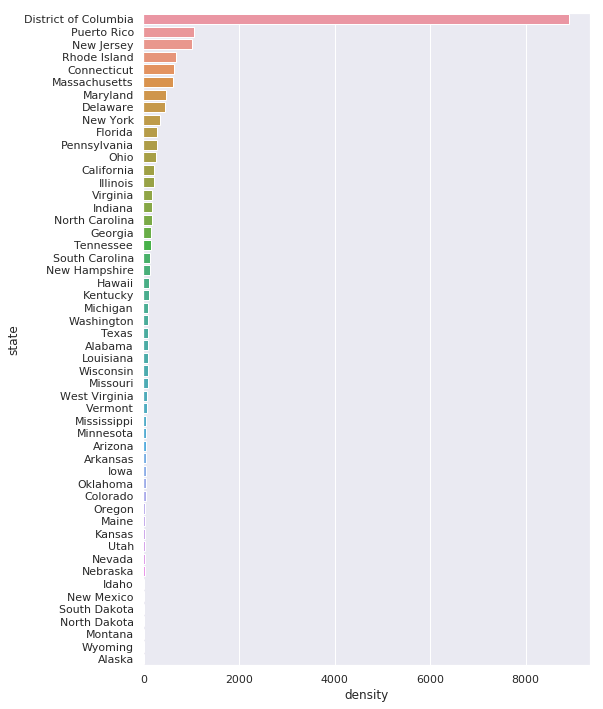

In [ ]:
# Don't run this cell to keep the outcome as your frame of reference
sns.barplot(y=data2010.index, x='density', data=data2010);

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-bar')

This type of messy data merging is a common task when trying to answer questions using real-world data sources.
I hope that this example has given you an idea of the ways you can combine tools we've covered in order to gain insight from your data!

## Plotting a heatmap

Below, we will use the **plotly** package to plot a population density heatmap of the US states.

In [ ]:
import plotly.express as px

df = data2010.reset_index()
# exluding District of Columbia & Puerto Rico for the purpose of creating a state map
df = df[~df['state'].isin(['District of Columbia', 'Puerto Rico'])].reset_index()

fig = px.choropleth(locations=df['state/region'], locationmode="USA-states", color=df['density'], scope="usa")
fig.show()